In [1]:
import pandas as pd
import numpy as np
import logging
log = logging.getLogger()
hdl = logging.StreamHandler()
hdl.setLevel(logging.DEBUG)
log.addHandler(hdl)
log.setLevel(logging.DEBUG)

In [30]:
genelist=pd.read_csv("https://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel()
url = "https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz"
df_tissues = pd.read_csv(url, compression="gzip", sep="\t", skiprows=2, index_col=0).drop("Description",1)

#filter proteincoding
df_tissues.index=[g[:15] for g in df_tissues.index]
df_tissues = df_tissues[df_tissues.index.isin(genelist)]

# group by tissue
df_tissues = df_tissues.transpose()
df_tissues["tissue"]=[t.split(" -")[0] for t in df_tissues.index]
df_tissues=df_tissues.groupby("tissue").mean()

#center
df_tissues = df_tissues.applymap(lambda tpm: np.log2(tpm+1))
df_tissues = df_tissues.subtract(df_tissues.mean(0),1)

print(df_tissues.shape)
df_tissues.head(2)

(31, 15177)


,ENSG00000227232,ENSG00000238009,ENSG00000268903,ENSG00000269981,ENSG00000228463,ENSG00000237094,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000177989,ENSG00000205560,ENSG00000100288,ENSG00000205559,ENSG00000008735,ENSG00000100299,ENSG00000251322,ENSG00000213683,ENSG00000184319,ENSG00000079974
tissue,,,,,,,,,,,,,,,,,,,,,
Adipose,-0.072781,-0.016123,-0.413811,-0.481595,0.277221,-0.089410,0.445273,0.854752,-0.068139,0.055197,...,1.024394,-0.475395,0.108324,0.114713,-0.540439,0.065159,1.980582,-0.006950,0.314889,-0.185224
Adrenal Gland,-0.428968,-0.021500,-0.568785,-0.474800,0.125517,-0.221988,0.721652,0.790095,1.215279,0.705056,...,-1.090338,-0.945978,-0.006722,0.243708,1.869963,-0.251334,-0.925108,-0.041288,-0.112895,-0.589531


In [31]:
from sklearn.decomposition import PCA
pca = PCA(31)
data = pca.fit_transform(df_tissues.values)

In [32]:
from hopfield4py import Hopfield
from hopfield4py.hopfield_helper import *
import tensorflow as tf

In [97]:
data_tf=tf.convert_to_tensor((data>0).astype(int)*2-1, dtype=tf.int8)

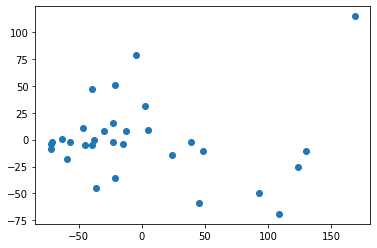

In [98]:
import matplotlib.pyplot as plt
plt.scatter([x[0] for x in data], [x[1] for x in data])

In [99]:
model = Hopfield(data.shape[1])
model.load_Kanter_Sompolinsky87(data_tf)
model.train()

[2021-02-24 19:05:34,280] Creating model..
Creating model..
[2021-02-24 19:05:34,281] Loading data...
Loading data...
[2021-02-24 19:05:34,291] Training...
Training...


In [100]:
reals = df_tissues.index
preds = get_predicted_labels(df_tissues.index, data_tf, data_tf, model)

[2021-02-24 19:05:36,801] Reconstructing...
Reconstructing...
[2021-02-24 19:05:36,819] Training...
Training...


In [101]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [102]:
classes=[l.split("-")[0] for l in df_tissues.index]

In [103]:
@tf.function
def get_distance_matrix(data_tensor, model, distance=hamming):
    return tf.map_fn(lambda A: tf.map_fn(lambda B: tf.reduce_min([tf.cast(distance(B,model.reconstruct(A)),tf.float64)]), tf.cast(data_tensor,tf.float64), parallel_iterations=6), tf.cast(data_tensor,tf.float64), parallel_iterations=6)

dist_matrix = get_distance_matrix(data_tf, model, dilutedhamming)

[2021-02-24 19:05:41,626] Reconstructing...
Reconstructing...
[2021-02-24 19:05:41,643] Training...
Training...


locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe644a09f70>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe644a09f70> on colorbar
Setting pcolormesh


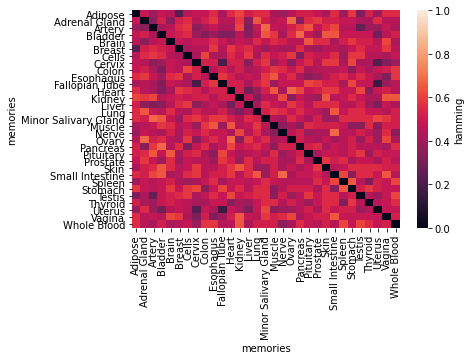

In [104]:
ax = sns.heatmap(dist_matrix, 
            vmin=0, 
            vmax=1, 
            xticklabels=classes, 
            yticklabels=classes,
            cbar_kws={"label":"hamming"})

ax.set_xlabel("memories")
ax.set_ylabel("memories")
plt.show()

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe6453d1e20>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe6453d1e20> on colorbar
Setting pcolormesh


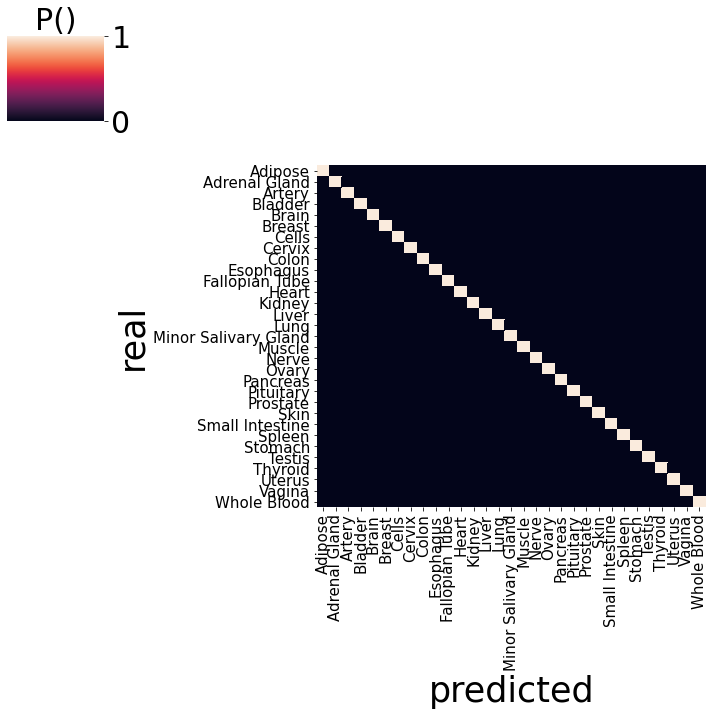

In [105]:
cm = sns.clustermap(confusion_matrix(reals, preds, normalize="true"),
                    vmin = 0,
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes, 
                    yticklabels=classes,
                    annot=False,
                    annot_kws={"fontsize":15})
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes, rotation=90)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=15)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
#cm.savefig(f"predict_{label}.pdf")

plt.show()

## Test samples

In [14]:
#GTEx
df_generator = pd.read_csv('../GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct', skiprows=2, sep='\t', chunksize=2000)

log.info("read generator")

df = pd.DataFrame()
df = next(df_generator)
df['ensg'] = [x[:15] for x in df['Name']]
df.reindex(index=df.index[df.index.isin(genelist)])
df.set_index("ensg", inplace=True)
df.drop(["Name", "Description"], axis=1, inplace=True)

log.info("first chunk OK")

for subdf in df_generator:
    subdf['ensg'] = [x[:15] for x in subdf['Name']]
    subdf.set_index("ensg", inplace=True)
    subdf.drop(["Name", "Description"], axis=1, inplace=True)
    df = df.append(subdf.reindex(index=subdf.index[subdf.index.isin(genelist)]))
    log.debug("new chunk")
    log.info(df.shape)

read generator
first chunk OK
new chunk
(2617, 17382)
new chunk
(3177, 17382)
new chunk
(3659, 17382)
new chunk
(4335, 17382)
new chunk
(4878, 17382)
new chunk
(5305, 17382)
new chunk
(5747, 17382)
new chunk
(6344, 17382)
new chunk
(6911, 17382)
new chunk
(7451, 17382)
new chunk
(7924, 17382)
new chunk
(8379, 17382)
new chunk
(8996, 17382)
new chunk
(9629, 17382)
new chunk
(10180, 17382)
new chunk
(10767, 17382)
new chunk
(11288, 17382)
new chunk
(11754, 17382)
new chunk
(12214, 17382)
new chunk
(12868, 17382)
new chunk
(13482, 17382)
new chunk
(14142, 17382)
new chunk
(14747, 17382)
new chunk
(15534, 17382)
new chunk
(16022, 17382)
new chunk
(16444, 17382)
new chunk
(16444, 17382)
new chunk
(16444, 17382)


In [17]:
df_files = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", index_col=0, sep="\t")

In [ ]:
#sample
log.info("sample")
df = df.sample(n=1000, axis=1)

# transpose
log.info("transpose")
df = df.transpose()
df = df.reindex(columns=df_tissues.columns)

#center
log.info("center")
df = df.applymap(lambda tpm: np.log2(tpm+1))
df = df.subtract(df.mean(0),1)

#group by tissue
df["tissue"]=df_files.reindex(index=df.index)["SMTS"]

df.head(2)

In [106]:
new_data_tf=tf.convert_to_tensor((pca.transform(df.drop("tissue", 1))>0).astype(int)*2-1, tf.int8)
preds = get_predicted_labels(df["tissue"], new_data_tf, data_tf, model)
reals = df["tissue"].values
classes=np.unique(df_tissues.index[df_tissues.index.isin(reals)])

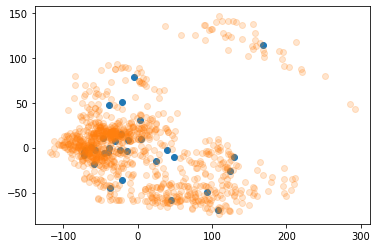

In [128]:
plt.scatter([x[0] for x in data], [x[1] for x in data])
plt.scatter([x[0] for x in pca.transform(df.drop("tissue", 1))], [x[1] for x in pca.transform(df.drop("tissue", 1))], alpha=0.2)